In [63]:
#%pip install wordcloud
#%pip install regex
#%pip install nltk
#%pip instal sklearn
#%pip install matplotlib.pyplot as plt

In [64]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import regex as re
from nltk import download
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from pickle import dump

In [65]:
%pip install wordcloud




[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [66]:
data = pd.read_csv("https://raw.githubusercontent.com/4GeeksAcademy/NLP-project-tutorial/main/url_spam.csv")
data

,url,is_spam
0,https://briefingday.us8.list-manage.com/unsubs...,True
1,https://www.hvper.com/,True
2,https://briefingday.com/m/v4n3i4f3,True
3,https://briefingday.com/n/20200618/m#commentform,False
4,https://briefingday.com/fan,True
...,...,...
2994,https://www.smartcitiesworld.net/news/news/dee...,False
2995,https://www.youtube.com/watch,True
2996,https://techcrunch.com/2019/07/04/an-optimisti...,False
2997,https://www.technologyreview.com/2019/12/20/13...,False


In [67]:
print(data["is_spam"].unique())

[ True False]


In [68]:

data["is_spam"] = data["is_spam"].apply(lambda x: 1 if str(x).strip().lower() == "true" else 0).astype(int)
data.head()

,url,is_spam
0,https://briefingday.us8.list-manage.com/unsubs...,1
1,https://www.hvper.com/,1
2,https://briefingday.com/m/v4n3i4f3,1
3,https://briefingday.com/n/20200618/m#commentform,0
4,https://briefingday.com/fan,1


In [69]:
print(data.shape)
print(f"Spam: {len(data.loc[data.is_spam == 1])}")
print(f"No spam: {len(data.loc[data.is_spam == 0])}")

(2999, 2)
Spam: 696
No spam: 2303


In [70]:
data = data.drop_duplicates().reset_index(drop = True)

data.shape

(2369, 2)

In [71]:
import regex as re

def preprocess_text(text):
    # Remove any character that is not a letter (a-z) or white space ( )
    text = re.sub(r'[^a-z ]', " ", text)
    
    # Remove white spaces
    text = re.sub(r'\s+[a-zA-Z]\s+', " ", text)
    text = re.sub(r'\^[a-zA-Z]\s+', " ", text)

    # Multiple white spaces into one
    text = re.sub(r'\s+', " ", text.lower())

    # Remove tags
    text = re.sub("&lt;/?.*?&gt;"," &lt;&gt; ", text)

    return text.split()

data["Message"] = data["url"].apply(preprocess_text)
data.head()

,url,is_spam,Message
0,https://briefingday.us8.list-manage.com/unsubs...,1,"[https, briefingday, us, list, manage, com, un..."
1,https://www.hvper.com/,1,"[https, www, hvper, com]"
2,https://briefingday.com/m/v4n3i4f3,1,"[https, briefingday, com, v, i]"
3,https://briefingday.com/n/20200618/m#commentform,0,"[https, briefingday, com, m, commentform]"
4,https://briefingday.com/fan,1,"[https, briefingday, com, fan]"


In [72]:
#Alejandro Hohmann
#7:59 PM
# alternate
#from nltk.corpus import words
#Russell Coonley
#8:41 PM
#[lemmatizer.lemmatize(word) for word in words if word not in stop_words and len(word) < 3]  <-- 1 line instead of 3

In [73]:
from nltk import download
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
download("wordnet")
lemmatizer = WordNetLemmatizer()

download("stopwords")
stop_words = stopwords.words("english")

def lemmatize_text(words, lemmatizer = lemmatizer):
    tokens = [lemmatizer.lemmatize(word) for word in words]
    tokens = [word for word in tokens if word not in stop_words]
    tokens = [word for word in tokens if len(word) > 3]
    return tokens

data["Message"] = data["Message"].apply(lemmatize_text)
data.head()

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,url,is_spam,Message
0,https://briefingday.us8.list-manage.com/unsubs...,1,"[http, briefingday, list, manage, unsubscribe]"
1,https://www.hvper.com/,1,"[http, hvper]"
2,https://briefingday.com/m/v4n3i4f3,1,"[http, briefingday]"
3,https://briefingday.com/n/20200618/m#commentform,0,"[http, briefingday, commentform]"
4,https://briefingday.com/fan,1,"[http, briefingday]"


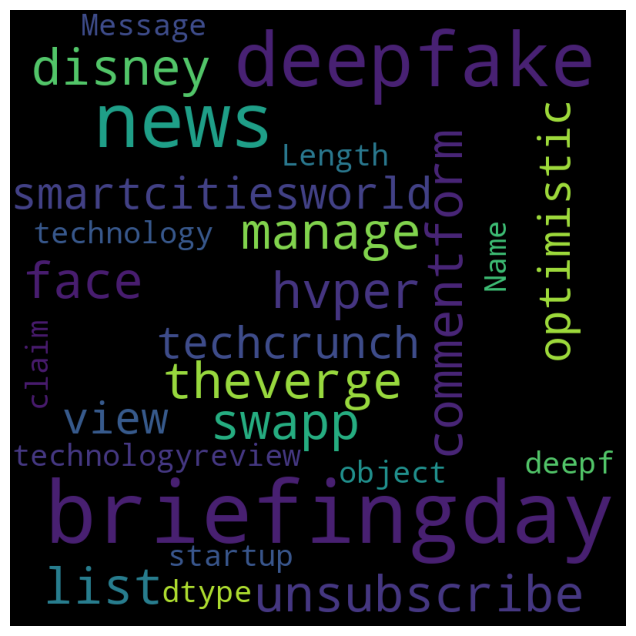

In [74]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

wordcloud = WordCloud(width = 800, height = 800, background_color = "black", max_words = 1000, min_font_size = 20, random_state = 42)\
    .generate(str(data["Message"]))

fig = plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [75]:
from sklearn.feature_extraction.text import TfidfVectorizer

tokens_list = data["Message"]
tokens_list = [" ".join(tokens) for tokens in tokens_list]

vectorizer = TfidfVectorizer(max_features = 5000, max_df = 0.8, min_df = 5)
X = vectorizer.fit_transform(tokens_list).toarray()
y = data["is_spam"]

X[:5]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], shape=(5, 538))

In [76]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)


In [77]:
from sklearn.model_selection import GridSearchCV  
from sklearn.ensemble import RandomForestClassifier  

# Define the model  
model = SVC(kernel = "rbf", C = 1.0, gamma = 0.5) 

# Define the hyperparameter grid  
param_grid = {  
    'C': [0.1, 1.0, 10.0],  # Regularization parameter  
    'gamma': [0.01, 0.1, 0.5, 1.0]  # Kernel coefficient  
}  

# Set up the grid search  
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5)  

# Fit the grid search to the data  
grid_search.fit(X_train, y_train)  

# Get the best parameters  
best_params = grid_search.best_params_  
print("Best parameters:", best_params)  

Best parameters: {'C': 10.0, 'gamma': 0.1}


In [78]:
from sklearn.svm import SVC

model = SVC(kernel = "linear", random_state = 42)
model.fit(X_train, y_train)

SVC(kernel='linear', random_state=42)

In [79]:
y_pred = model.predict(X_test)
y_pred

array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,

In [80]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)

0.9514767932489452

In [81]:
model = SVC(kernel = "rbf", C = 1.0, gamma = 0.5)
model.fit(X_train, y_train)


SVC(gamma=0.5)

In [82]:
y_pred = model.predict(X_test)
y_pred

array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [83]:
accuracy_score(y_test, y_pred)

0.9578059071729957

In [84]:
model = SVC(kernel = "rbf", C = 10, gamma = 0.1)
model.fit(X_train, y_train)

SVC(C=10, gamma=0.1)

In [85]:
y_pred = model.predict(X_test)
y_pred

array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,

In [86]:
accuracy_score(y_test, y_pred)

0.9620253164556962

In [87]:
from sklearn.model_selection import RandomizedSearchCV  
from sklearn.svm import SVC  
import numpy as np  

# Define the model  
model = SVC(kernel="rbf")  

# Define the hyperparameter distribution  
param_distributions = {  
    'C': np.logspace(-3, 3, 7),  # Values from 0.001 to 1000  
    'gamma': np.logspace(-3, 3, 7)  # Values from 0.001 to 1000  
}  

# Set up the random search  
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_distributions, n_iter=20, cv=5, random_state=42)  

# Fit the random search to the data  
random_search.fit(X_train, y_train)  

# Get the best parameters  
best_params = random_search.best_params_  
print("Best parameters:", best_params)  

Best parameters: {'gamma': np.float64(1.0), 'C': np.float64(1000.0)}


In [88]:
model = SVC(kernel = "rbf", C = np.float64(1000.0), gamma = np.float64(1.0))
model.fit(X_train, y_train)

SVC(C=np.float64(1000.0), gamma=np.float64(1.0))

In [89]:
y_pred = model.predict(X_test)
y_pred

array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,

In [91]:
accuracy_score(y_test, y_pred)

0.9556962025316456

In [ ]:
#the best model to use is kernel = "rbf" and using grid search

In [92]:
from pickle import dump
dump(model, open("svm_classifier_rbf_42.sav", "wb"))